DESCRIPTON
----------

This dataset is composed of 1200 samples with 25 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 4 possible values for the labels. The remaining columns are numeric
features.

Notice that the classes are unbalanced: some labels are more frequent than
others. You need to decide whether to take this into account, and if so how.

Your task is the following: you should compare the performance of the
k-NearestNeighbors algorithm (implemented by
sklearn.neighbors.KNeighborsClassifier) with that of Logistic Regression
(implemented by sklearn.linear_model.LogisticRegression). Try to optimize both
algorithms' parameters and determine which one is best for this dataset. At the
end of the analysis, you should have chosen an algorithm and its optimal set of
parameters: write this choice explicitly in the conclusions of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

## Index:
* [Index](#index)
* [Data Preparation and Exploration](#data-preparation-and-exploration)
* [Training The Models](#training-the-models)
    * [Logistic Regression](#logistic-regression)
    * [K Nearest Neighbors](#k-nearest-neighbors)
* [Performance Check](#performance-check)
* [Conclusion](#conclusion)

In [202]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import make_scorer, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier

#to make runs stable for now
np.random.seed(31)

#for colorful conf. matrices
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel("predicted")
    ax.set_ylabel("true")
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

#for quick printing of scores
def model_evaluation(y_true , y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="micro"))
    print('Recall:', recall_score(y_true, y_pred, average="micro"))
    print('F1 score:', f1_score(y_true, y_pred, average="micro"))
    print('Cohen\'s Kappa', cohen_kappa_score(y_true, y_pred))
    pass

kappa_score = make_scorer(cohen_kappa_score)

def model_evaluation_cv(estimator, X , y, cv=3):
    cv_acc = cross_val_score(estimator, X, y, cv=cv, scoring="accuracy")
    cv_prc = cross_val_score(estimator, X, y, cv=cv, scoring="precision_micro")
    cv_rec = cross_val_score(estimator, X, y, cv=cv, scoring="recall_micro")
    cv_f1 = cross_val_score(estimator, X, y, cv=cv, scoring="f1_micro")
    cv_kappa = cross_val_score(estimator, X, y, cv=cv, scoring=kappa_score)

    print('Mean Accuracy:', cv_acc.mean(), "Standard Deviation", cv_acc.std())
    print('Mean Precision:', cv_prc.mean(), "Standard Deviation", cv_prc.std())
    print('Mean Recall:', cv_rec.mean(), "Standard Deviation", cv_rec.std())
    print('Mean F1 score:', cv_f1.mean(), "Standard Deviation", cv_f1.std())
    print('Mean Cohen\'s Kappa', cv_kappa.mean(), "Standard Deviation",
          cv_kappa.std())
    pass

# Data Preparation and Exploration

In [203]:
df = pd.read_csv(os.path.join("mldata_0013123308.csv"), index_col=0)
#the first column are integrated as indices

In [204]:
df.head()

label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      3  -3.408546   3.112290  -0.186409  -0.748929   2.818303   1.060735   
1      2   1.774793   1.925047  -0.210903  -1.341213  -1.617804  -0.762783   
2      2   1.368095  -0.909900   0.036867   0.001949  -1.125134  -1.214954   
3      1   5.077667  -1.458279   0.022319   0.141118  -0.854731   0.769729   
4      1   0.513609  -0.408709   1.671109   0.245527  -1.921868   0.643637   

   feature_7  feature_8  feature_9  ...  feature_16  feature_17  feature_18  \
0   1.940521  -0.263668   4.244502  ...   -3.135272    0.884255    0.513300   
1   0.401746  -0.514656  -1.609881  ...   -1.247456   -3.218347    0.306005   
2   1.209467  -0.870477   1.841165  ...   -0.469398    0.430646    0.491892   
3  -4.503366   1.362667  -3.687085  ...    0.554069   -2.688564    0.851376   
4  -2.177245  -1.164815  -1.577875  ...   -1.669569   -2.906270   -0.045091   

   feature_19  feature_20  feature_21  feature_22  feature_23  feature_24  \
0   -0.235169   -2.170921    1.018778   -1.000973    1.073991    1.671980   
1    2.121760   -1.322266    1.149706    0.352306   -0.352055   -0.477163   
2   -2.090153   -0.056803    0.295180   -0.115531    0.159554   -0.817442   
3    0.824690    0.449504   -0.331201    1.825498   -0.202762   -0.845550   
4    0.645292   -0.029681   -0.245088    1.939267    0.642765   -0.704881   

   feature_25  
0   -0.368852  
1    0.527185  
2   -2.545887  
3   -2.004207  
4    2.363812  

[5 rows x 26 columns]

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       1200 non-null   int64  
 1   feature_1   1200 non-null   float64
 2   feature_2   1200 non-null   float64
 3   feature_3   1200 non-null   float64
 4   feature_4   1200 non-null   float64
 5   feature_5   1200 non-null   float64
 6   feature_6   1200 non-null   float64
 7   feature_7   1200 non-null   float64
 8   feature_8   1200 non-null   float64
 9   feature_9   1200 non-null   float64
 10  feature_10  1200 non-null   float64
 11  feature_11  1200 non-null   float64
 12  feature_12  1200 non-null   float64
 13  feature_13  1200 non-null   float64
 14  feature_14  1200 non-null   float64
 15  feature_15  1200 non-null   float64
 16  feature_16  1200 non-null   float64
 17  feature_17  1200 non-null   float64
 18  feature_18  1200 non-null   float64
 19  feature_19  1200 non-null  

In [206]:
df.describe()

label    feature_1    feature_2    feature_3    feature_4  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      1.641667    -0.194460     0.078757     0.066431     0.084984   
std       0.977613     3.577982     1.783342     1.007320     1.004302   
min       0.000000   -11.742788    -5.820555    -3.803068    -3.090761   
25%       1.000000    -2.755719    -0.965521    -0.631341    -0.573135   
50%       2.000000    -0.443599     0.108370     0.065087     0.096484   
75%       2.000000     2.418469     1.210259     0.748791     0.768122   
max       3.000000    11.308111     5.603574     3.365835     3.624312   

         feature_5    feature_6    feature_7    feature_8    feature_9  ...  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000  ...   
mean     -0.037681     0.097897     0.179606     0.120068     0.050957  ...   
std       2.046271     1.019476     2.725408     1.000555     2.946142  ...   
min      -7.809149    -3.918267    -8.769640    -2.728688    -9.138372  ...   
25%      -1.477599    -0.602012    -1.753573    -0.566274    -1.627882  ...   
50%      -0.074640     0.098812     0.364416     0.107149     0.080132  ...   
75%       1.414964     0.806476     2.132948     0.798140     1.967480  ...   
max       6.301655     3.185287     7.741892     3.218933     9.228765  ...   

        feature_16   feature_17   feature_18   feature_19   feature_20  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean     -0.339174    -0.282241     0.113984     0.029922    -0.103701   
std       1.900387     3.507690     1.010009     1.782992     2.017280   
min      -7.401784   -12.597340    -3.531474    -5.645280    -8.097192   
25%      -1.577516    -2.586458    -0.580568    -1.130394    -1.472807   
50%      -0.404653    -0.040819     0.071489     0.060329    -0.022167   
75%       1.001678     2.017489     0.790002     1.198601     1.327954   
max       7.027119    10.432275     3.338958     6.624124     5.431849   

        feature_21   feature_22   feature_23   feature_24   feature_25  
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000  
mean      0.378791     0.098208     0.097716     0.048196     0.197543  
std       1.726312     1.034443     1.012274     0.972767     1.793712  
min      -6.164760    -3.260489    -3.120135    -2.695448    -5.958548  
25%      -0.757760    -0.610395    -0.583407    -0.654184    -1.050933  
50%       0.513291     0.100499     0.096659     0.066052     0.176526  
75%       1.578467     0.792470     0.745912     0.715369     1.452025  
max       5.435101     3.131871     3.540104     3.461183     5.578674  

[8 rows x 26 columns]

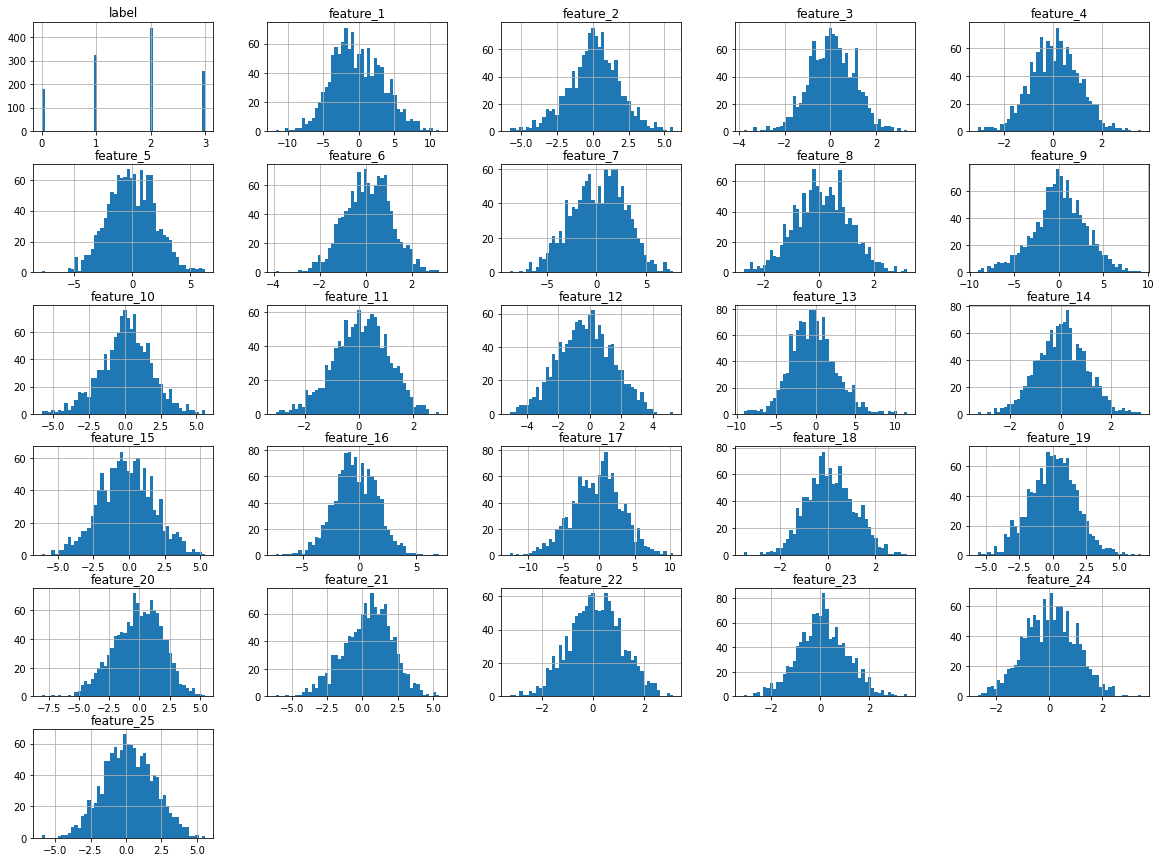

In [207]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Features generally *look* approximately normal, and there doesn't seem any big
scale differences.

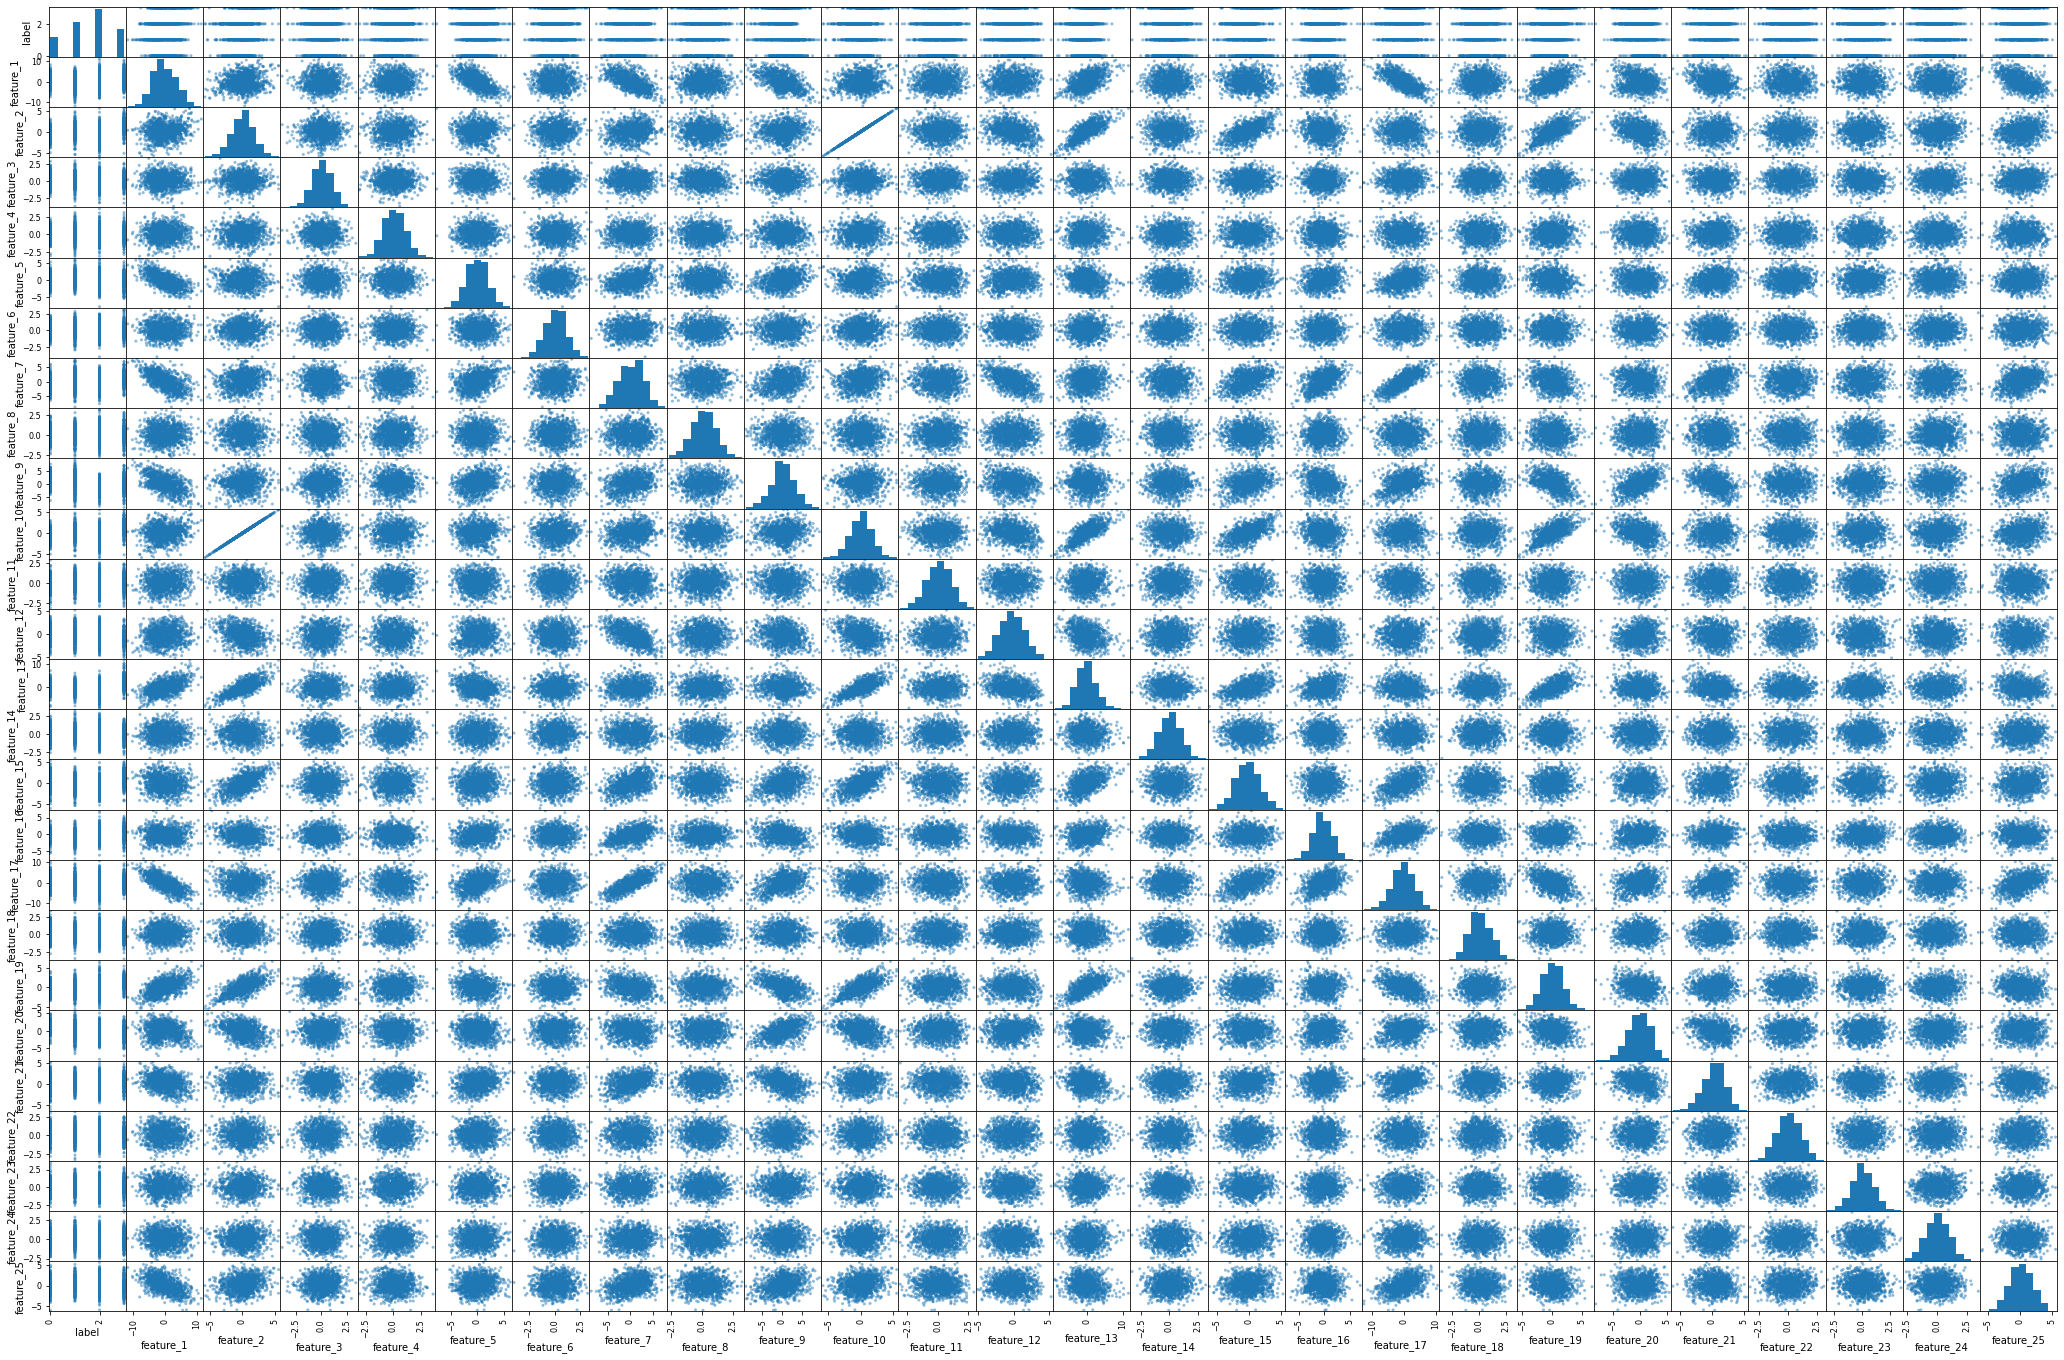

In [208]:
features = ["label"]
features.extend(f"feature_{i}" for i in range(1, 26))
scatter_matrix(df[features], figsize=(36, 24)) # to get a general feel
plt.show()

In [209]:
#better digestable version
df.corr().style.background_gradient(cmap="coolwarm", vmin=-1.0, vmax=1.0)

In [210]:
df.isnull().values.any()

False

In [211]:
np.any(df.duplicated())

False

In [212]:
df['label'].value_counts()

2    440
1    325
3    255
0    180
Name: label, dtype: int64

<AxesSubplot:>

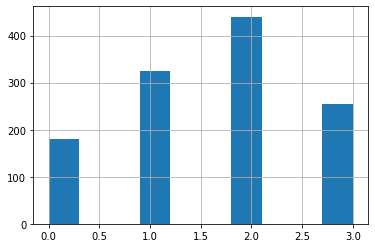

In [213]:
df["label"].hist()

Looks like the labels might be unbalanced. We do some further investigation on 
how this might reflect on train and test sets.

## Train/Test Splits

We do the splitting **before** we do any transformations to the data to prevent
data leakage and overly optimistic scores. We then apply any transformations,
which we fit on the **training set** on the **test set**, so that our model
does **not** see the model before even it's trained.

### Stratified

In [214]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(df, df["label"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

assert (len(strat_train_set) + len(strat_test_set)) == len(df)

X_train_strat = strat_train_set.drop(columns="label")
y_train_strat = strat_train_set["label"].copy()

X_test_strat = strat_test_set.drop(columns="label")
y_test_strat = strat_test_set["label"].copy()

### Without Stratification

In [215]:
train_set, test_set = train_test_split(df, test_size=0.2)
assert (len(train_set) + len(test_set)) == len(df)

X_train = train_set.drop(columns="label")
y_train = train_set["label"].copy()

X_test = test_set.drop(columns="label")
y_test = test_set["label"].copy()

### Compare the Proportions

In [216]:
def label_proportions(data):
    return data["label"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": label_proportions(df),
    "Stratified": label_proportions(strat_test_set),
    "Random": label_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = (100 * compare_props["Random"] 
                                 / compare_props["Overall"] - 100)
compare_props["Strat. %error"] = (100 * compare_props["Stratified"] 
                                  / compare_props["Overall"] - 100)

compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
0  0.150000    0.150000  0.112500    -25.000000            0.0
1  0.270833    0.270833  0.254167     -6.153846            0.0
2  0.366667    0.366667  0.404167     10.227273            0.0
3  0.212500    0.212500  0.229167      7.843137            0.0

We conclude that a stratified test set might represent our original dataset better.

## Standardization

In [217]:
standardizer = StandardScaler().fit(X_train_strat)
X_train_strat_std = standardizer.transform(X_train_strat)
X_test_strat_std = standardizer.transform(X_test_strat)

## Normalization

In [218]:
normalizer = MinMaxScaler().fit(X_train_strat)
X_train_strat_nrm = normalizer.transform(X_train_strat)
X_test_strat_nrm = normalizer.transform(X_test_strat)

## A Preliminary PCA Analysis

### PCA Without any Scaling

In [219]:
pca = PCA()

pca.fit(X_train_strat)

plt.plot(range(0, len(pca.explained_variance_)), 
         np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance vs Number Of Components")
plt.xlabel("Number Of Component")
plt.xticks(np.arange(0, 26))
plt.yticks(np.linspace(0, 1, num=11))
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

At the first glance, it seems like we can explain a whopping %90 (give or take)
of our variance with *only* 7 components. If this seems too good to be true,
because it **is**. For PCA to work correctly you need to standardize your data
i.e. it has to have zero mean and unit variance. If left unstandardized,
components with comparatively bigger scales dominate others in explained
variance, which leads to unreasonable results like this.

### PCA With Standardization

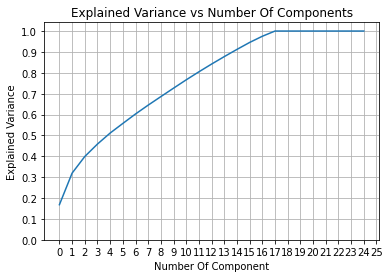

In [220]:
pca.fit(X_train_strat_std)

plt.plot(range(0, len(pca.explained_variance_)), 
         np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance vs Number Of Components")
plt.xlabel("Number Of Component")
plt.xticks(np.arange(0, 26))
plt.yticks(np.linspace(0, 1, num=11))
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

Now this is a more accurate result. We see that to explain at least %90 of our
variance, we need 14 components, **twice** the number we would have gone for if
we hadn't applied standardization.  

There is also one interesting observation, 18 components can explain our entire
variance (almost), whereas we originally had 25 features. This might suggest
some problems with collinearity.

In [221]:
pca_std = PCA(n_components=0.99)
X_train_strat_pca = pca_std.fit_transform(X_train_strat_std)
X_test_strat_pca = pca_std.transform(X_test_strat_std)

pca_std.n_components_

18

### PCA With Normalization

In [222]:
pca.fit_transform(X_train_strat_nrm)

plt.plot(range(0, len(pca.explained_variance_)),
         np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance vs Number Of Components")
plt.xlabel("Number Of Component")
plt.xticks(np.arange(0, 26))
plt.yticks(np.linspace(0, 1, num=11))
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

## Polynomial Features

### Degree 2

In [223]:
poly = PolynomialFeatures()
X_train_strat_poly = poly.fit_transform(X_train_strat)
X_test_strat_poly = poly.transform(X_test_strat)

X_train_strat_poly_std = standardizer.fit_transform(X_train_strat_poly)
X_test_strat_poly_std = standardizer.transform(X_train_strat_poly)

### Degree 3

In [224]:
poly3 = PolynomialFeatures(3)
X_train_strat_poly3 = poly3.fit_transform(X_train_strat)
X_test_strat_poly3 = poly3.transform(X_test_strat)

X_train_strat_poly3_std = standardizer.fit_transform(X_train_strat_poly3)
X_test_strat_poly3_std = standardizer.transform(X_train_strat_poly3)

### Degree 4

In [225]:
poly4 = PolynomialFeatures(4)
X_train_strat_poly4 = poly4.fit_transform(X_train_strat)
X_test_strat_poly4 = poly4.transform(X_test_strat)

X_train_strat_poly4_std = standardizer.fit_transform(X_train_strat_poly4)
X_test_strat_poly4_std = standardizer.transform(X_train_strat_poly4)

# Training The Models

## Logistic Regression

### Preliminary Trials

#### Without Standardization or Normalization

In [226]:
%%time
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_strat, y_train_strat)

lr_train_strat_pred = logreg.predict(X_train_strat)
model_evaluation(y_train_strat, lr_train_strat_pred)

Accuracy: 0.5333333333333333
Precision: 0.5333333333333333
Recall: 0.5333333333333333
F1 score: 0.5333333333333333
Cohen's Kappa 0.3386274304765303
Wall time: 163 ms


In [227]:
model_evaluation_cv(logreg, X_train_strat, y_train_strat)

Mean Accuracy: 0.4989583333333334 Standard Deviation 0.007795119555779061
Mean Precision: 0.4989583333333334 Standard Deviation 0.007795119555779061
Mean Recall: 0.4989583333333334 Standard Deviation 0.007795119555779061
Mean F1 score: 0.4989583333333334 Standard Deviation 0.007795119555779061
Mean Cohen's Kappa 0.2930555472348231 Standard Deviation 0.00642851108246889


#### Standardized

In [228]:
%%time
logreg.fit(X_train_strat_std, y_train_strat)

lr_train_strat_std_pred = logreg.predict(X_train_strat_std)
model_evaluation(y_train_strat, lr_train_strat_std_pred)

Accuracy: 0.5354166666666667
Precision: 0.5354166666666667
Recall: 0.5354166666666667
F1 score: 0.5354166666666667
Cohen's Kappa 0.3412558233994498
Wall time: 22 ms


In [229]:
model_evaluation_cv(logreg, X_train_strat_std, y_train_strat)

Mean Accuracy: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Precision: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Recall: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean F1 score: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Cohen's Kappa 0.2956084734574456 Standard Deviation 0.006670016532446002


#### Normalized

In [230]:
%%time
logreg.fit(X_train_strat_nrm, y_train_strat)

lr_train_strat_nrm_pred = logreg.predict(X_train_strat_nrm)
model_evaluation(y_train_strat, lr_train_strat_nrm_pred)

Accuracy: 0.5375
Precision: 0.5375
Recall: 0.5375
F1 score: 0.5375
Cohen's Kappa 0.33862548799334646
Wall time: 99 ms


In [231]:
model_evaluation_cv(logreg, X_train_strat_nrm, y_train_strat)

Mean Accuracy: 0.5208333333333334 Standard Deviation 0.005311478659992458
Mean Precision: 0.5208333333333334 Standard Deviation 0.005311478659992458
Mean Recall: 0.5208333333333334 Standard Deviation 0.005311478659992458
Mean F1 score: 0.5208333333333334 Standard Deviation 0.005311478659992458
Mean Cohen's Kappa 0.3136417703615673 Standard Deviation 0.0025729980830736117


#### PCA

In [232]:
%%time
logreg.fit(X_train_strat_pca, y_train_strat)

lr_train_strat_pca_pred = logreg.predict(X_train_strat_pca)
model_evaluation(y_train_strat, lr_train_strat_pca_pred)

Accuracy: 0.5354166666666667
Precision: 0.5354166666666667
Recall: 0.5354166666666667
F1 score: 0.5354166666666667
Cohen's Kappa 0.3412558233994498
Wall time: 32 ms


In [233]:
model_evaluation_cv(logreg, X_train_strat_pca, y_train_strat)

Mean Accuracy: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Precision: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Recall: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean F1 score: 0.5010416666666666 Standard Deviation 0.00820209153542894
Mean Cohen's Kappa 0.2956084734574456 Standard Deviation 0.006670016532446002


### Polynomial Features

#### Degree 2

In [234]:
%%time
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_strat_poly_std, y_train_strat)

lr_train_strat_poly_pred = logreg.predict(X_test_strat_poly_std)
model_evaluation(y_train_strat, lr_train_strat_poly_pred)

Accuracy: 0.921875
Precision: 0.921875
Recall: 0.921875
F1 score: 0.921875
Cohen's Kappa 0.8920966813734894
Wall time: 276 ms


In [235]:
model_evaluation_cv(logreg, X_train_strat_poly_std, y_train_strat, cv=3)

Mean Accuracy: 0.5614583333333333 Standard Deviation 0.005892556509887928
Mean Precision: 0.5614583333333333 Standard Deviation 0.005892556509887928
Mean Recall: 0.5614583333333333 Standard Deviation 0.005892556509887928
Mean F1 score: 0.5614583333333333 Standard Deviation 0.005892556509887928
Mean Cohen's Kappa 0.3936435832557576 Standard Deviation 0.00858242670639382


#### Degree 3

In [236]:
%%time
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_strat_poly3_std, y_train_strat)

lr_train_strat_poly3_pred = logreg.predict(X_train_strat_poly3_std)

model_evaluation(y_train_strat, lr_train_strat_poly3_pred)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Cohen's Kappa 1.0
Wall time: 1.26 s


In [237]:
model_evaluation_cv(logreg, X_train_strat_poly3_std, y_train_strat, cv=3)

Mean Accuracy: 0.5989583333333334 Standard Deviation 0.0038975597778895285
Mean Precision: 0.5989583333333334 Standard Deviation 0.0038975597778895285
Mean Recall: 0.5989583333333334 Standard Deviation 0.0038975597778895285
Mean F1 score: 0.5989583333333334 Standard Deviation 0.0038975597778895285
Mean Cohen's Kappa 0.43575392025987303 Standard Deviation 0.005171602572651761


#### Degree 4

In [238]:
%%time
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_strat_poly4_std, y_train_strat)

lr_train_strat_poly4_pred = logreg.predict(X_test_strat_poly4_std)
model_evaluation(y_train_strat, lr_train_strat_poly4_pred)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Cohen's Kappa 1.0
Wall time: 14.4 s


In [239]:
model_evaluation_cv(logreg, X_train_strat_poly4_std, y_train_strat)

Mean Accuracy: 0.5750000000000001 Standard Deviation 0.011692679333668594
Mean Precision: 0.5750000000000001 Standard Deviation 0.011692679333668594
Mean Recall: 0.5750000000000001 Standard Deviation 0.011692679333668594
Mean F1 score: 0.5750000000000001 Standard Deviation 0.011692679333668594
Mean Cohen's Kappa 0.39456366512137775 Standard Deviation 0.01564872479615057


With the non polynomial featureset, every transformation had comparable
performance, but varying speed, with PCA being the fastest.
But finding the performance unsatisfactory, I have decided to try and see what
effect a polynomial featureset might have on the performance.

The polynomial featuresets have the better scores, but take considerably longer
to fit.
Comparing the initial evaluations with the cross-validated ones gives us an
idea if the model's overfitting or not. We see the 3rd degree one might be,
we still included the model in the fine-tuning section just to be sure. 

Thus, we will try Logistic Regression models with 
**PCA**/**second**/**third degree featureset** in the fine-tuning section.

## Fine-Tuning

### PCA

In [240]:
%%time
parameters1 = [{"penalty":["l1","l2"],"C":np.logspace(-4,4,50),
               "solver":["liblinear"]},
              {"penalty":["elasticnet"], "l1_ratio":range(0,1,20),
               "C":np.logspace(-4,4,50), "solver": ["saga"]},
              {"penalty": ["l2"], "C": np.logspace(-4, 4, 100),
               "solver": ["newton-cg", "lbfgs", "sag"]}  
             ]

parameters2 = [
    {"penalty": ["elasticnet"],"C": np.logspace(-4, 4, 50),
     "l1_ratio":np.linspace(0, 1, 5), "solver": ["saga"]}
]

parameters3 = [
    {"C": np.logspace(-4, 4, 10)}
]

logreg = LogisticRegression(max_iter = 1000)
logreg_rnd = RandomizedSearchCV(logreg, parameters1, scoring="f1_micro", 
                                 n_iter=50)
logreg_rnd.fit(X_train_strat_pca, y_train_strat)

best_lr = logreg_rnd.best_estimator_

logreg_rnd_pred = best_lr.predict(X_train_strat_pca)
model_evaluation(y_train_strat, logreg_rnd_pred)

Accuracy: 0.5416666666666666
Precision: 0.5416666666666666
Recall: 0.5416666666666666
F1 score: 0.5416666666666666
Cohen's Kappa 0.3331775730442085
Wall time: 4.36 s


In [241]:
model_evaluation_cv(best_lr, X_train_strat_pca, y_train_strat)

Mean Accuracy: 0.509375 Standard Deviation 0.0044194173824158795
Mean Precision: 0.509375 Standard Deviation 0.0044194173824158795
Mean Recall: 0.509375 Standard Deviation 0.0044194173824158795
Mean F1 score: 0.509375 Standard Deviation 0.0044194173824158795
Mean Cohen's Kappa 0.28014994309375824 Standard Deviation 0.005394015634192079


### Degree 3

Using LogisticRegressionCV to make use of warm-starting in order to boost
fitting speed for the polynomial featuremap.

In [242]:
%%time
logreg_cv = LogisticRegressionCV(
    max_iter=1000, scoring="f1_micro", penalty="elasticnet", 
    solver="saga", l1_ratios=[0.25, 0.5, 0.75], n_jobs=2, tol=0.01
)

logreg_cv.fit(X_train_strat_poly3_std, y_train_strat)
best_lr_cv = LogisticRegression(
    C=logreg_cv.C_[0], l1_ratio=logreg_cv.l1_ratio_[0], solver="saga",
    penalty="elasticnet", max_iter=1000, tol=0.01
)

logreg_cv_pred = logreg_cv.predict(X_train_strat_poly3_std)
model_evaluation(y_train_strat, logreg_cv_pred)

Accuracy: 0.903125
Precision: 0.903125
Recall: 0.903125
F1 score: 0.903125
Cohen's Kappa 0.8648959480890525
Wall time: 2min 28s


In [243]:
model_evaluation_cv(best_lr_cv, X_train_strat_poly3_std, y_train_strat, cv=3)

Mean Accuracy: 0.6291666666666668 Standard Deviation 0.016601434844280453
Mean Precision: 0.6281249999999999 Standard Deviation 0.015309310892394854
Mean Recall: 0.6322916666666667 Standard Deviation 0.016989069198229262
Mean F1 score: 0.63125 Standard Deviation 0.01275775907699572
Mean Cohen's Kappa 0.4866552875381604 Standard Deviation 0.019277515428384014


### Degree 2

In [244]:
%%time
logreg_cv = LogisticRegressionCV(
    max_iter=1000, scoring="f1_micro", penalty="elasticnet", 
    solver="saga", l1_ratios=[0.25, 0.5, 0.75], n_jobs=2, tol=0.01
)

logreg_cv.fit(X_train_strat_poly_std, y_train_strat)
best_lr_cv = LogisticRegression(
    C=logreg_cv.C_[0], l1_ratio=logreg_cv.l1_ratio_[0], solver="saga",
    penalty="elasticnet", max_iter=1000, tol=0.01
)

logreg_cv_pred = logreg_cv.predict(X_train_strat_poly_std)
model_evaluation(y_train_strat, logreg_cv_pred)

Accuracy: 0.7541666666666667
Precision: 0.7541666666666667
Recall: 0.7541666666666667
F1 score: 0.7541666666666665
Cohen's Kappa 0.6521995431434677
Wall time: 10 s


In [245]:
model_evaluation_cv(best_lr_cv, X_train_strat_poly_std, y_train_strat, cv=3)

Mean Accuracy: 0.6322916666666667 Standard Deviation 0.006421264586426019
Mean Precision: 0.6322916666666666 Standard Deviation 0.00736569563735987
Mean Recall: 0.63125 Standard Deviation 0.0076546554461974494
Mean F1 score: 0.6333333333333333 Standard Deviation 0.005311478659992473
Mean Cohen's Kappa 0.4785450131003734 Standard Deviation 0.0038770367264514935


We pick the second degree model as the most promising one as its scores are
very close the third degree one, with much more stability seen in the form of
much lower standard deviation, whereas PCA lacks explanatory power.

## K Nearest Neighbors

### Preliminary Trials

#### Without Standardization or Normalization

In [246]:
%%time
k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train_strat, y_train_strat)

knn_train_strat_pred = k_neighbors.predict(X_train_strat)
model_evaluation(y_train_strat, knn_train_strat_pred)

Accuracy: 0.8041666666666667
Precision: 0.8041666666666667
Recall: 0.8041666666666667
F1 score: 0.8041666666666667
Cohen's Kappa 0.7267077735647918
Wall time: 109 ms


In [247]:
model_evaluation_cv(k_neighbors, X_train_strat, y_train_strat)

Mean Accuracy: 0.6906249999999999 Standard Deviation 0.020885351724753583
Mean Precision: 0.6906249999999999 Standard Deviation 0.020885351724753583
Mean Recall: 0.6906249999999999 Standard Deviation 0.020885351724753583
Mean F1 score: 0.6906249999999999 Standard Deviation 0.020885351724753583
Mean Cohen's Kappa 0.5653998809135407 Standard Deviation 0.028464255259649737


#### Standardized

In [248]:
%%time
k_neighbors.fit(X_train_strat_std, y_train_strat)

knn_train_strat_std_pred = k_neighbors.predict(X_train_strat_std)
model_evaluation(y_train_strat, knn_train_strat_std_pred)

Accuracy: 0.7541666666666667
Precision: 0.7541666666666667
Recall: 0.7541666666666667
F1 score: 0.7541666666666665
Cohen's Kappa 0.655264759586123
Wall time: 93 ms


In [249]:
model_evaluation_cv(k_neighbors, X_train_strat_std, y_train_strat)

Mean Accuracy: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Precision: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Recall: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean F1 score: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Cohen's Kappa 0.4206867555485019 Standard Deviation 0.011657943825509555


#### Normalized

In [250]:
%%time
k_neighbors.fit(X_train_strat_nrm, y_train_strat)

knn_train_strat_nrm_pred = k_neighbors.predict(X_train_strat_nrm)
model_evaluation(y_train_strat, knn_train_strat_nrm_pred)

Accuracy: 0.7489583333333333
Precision: 0.7489583333333333
Recall: 0.7489583333333333
F1 score: 0.7489583333333333
Cohen's Kappa 0.6474482052407337
Wall time: 99 ms


In [251]:
model_evaluation_cv(k_neighbors, X_train_strat_nrm, y_train_strat)

Mean Accuracy: 0.5833333333333334 Standard Deviation 0.021245914639969964
Mean Precision: 0.5833333333333334 Standard Deviation 0.021245914639969964
Mean Recall: 0.5833333333333334 Standard Deviation 0.021245914639969964
Mean F1 score: 0.5833333333333334 Standard Deviation 0.021245914639969964
Mean Cohen's Kappa 0.4117186063813536 Standard Deviation 0.0291413679502875


#### PCA

In [252]:
%%time
k_neighbors.fit(X_train_strat_pca, y_train_strat)

knn_train_strat_pca_pred = k_neighbors.predict(X_train_strat_pca)
model_evaluation(y_train_strat, knn_train_strat_pca_pred)

Accuracy: 0.7541666666666667
Precision: 0.7541666666666667
Recall: 0.7541666666666667
F1 score: 0.7541666666666665
Cohen's Kappa 0.655264759586123
Wall time: 87 ms


In [253]:
model_evaluation_cv(k_neighbors, X_train_strat_pca, y_train_strat)

Mean Accuracy: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Precision: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Recall: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean F1 score: 0.5895833333333332 Standard Deviation 0.007795119555779017
Mean Cohen's Kappa 0.4206867555485019 Standard Deviation 0.011657943825509555


### Degree 2

In [254]:
%%time
k_neighbors.fit(X_train_strat_poly, y_train_strat)

knn_train_strat_poly_pred = k_neighbors.predict(X_train_strat_poly)
model_evaluation(y_train_strat, knn_train_strat_poly_pred)

Accuracy: 0.7520833333333333
Precision: 0.7520833333333333
Recall: 0.7520833333333333
F1 score: 0.7520833333333333
Cohen's Kappa 0.6512352086360805
Wall time: 117 ms


In [255]:
model_evaluation_cv(k_neighbors, X_train_strat_poly, y_train_strat)

Mean Accuracy: 0.5947916666666666 Standard Deviation 0.012058163440406468
Mean Precision: 0.5947916666666666 Standard Deviation 0.012058163440406468
Mean Recall: 0.5947916666666666 Standard Deviation 0.012058163440406468
Mean F1 score: 0.5947916666666666 Standard Deviation 0.012058163440406468
Mean Cohen's Kappa 0.4249207399172417 Standard Deviation 0.014051138282779409


The KNN model without any data transformation scored the best, with scores having
comparable stability with other models. This might suggest that in the data we
have, the scales (as-is) most probably aren't misleading, but informative.

### Fine Tuning

The most successful model in preliminary testing was K Nearest Neighbors
without Standardization or Normalization, so we continue hyperparameter testing
on that model.

In [257]:
%%time
parameters = {
    "n_neighbors": np.arange(1, 25), "weights": ["uniform", "distance"],
    "leaf_size": [30, 40, 50],
    "metric": ["euclidean", "manhattan", "minkowski"] 
    }

knn = KNeighborsClassifier(n_jobs=2)
knn_grid = GridSearchCV(knn, parameters, scoring="f1_micro", verbose=1, 
                        cv=3)
knn_grid.fit(X_train_strat, y_train_strat)

best_knn = knn_grid.best_estimator_

knn_grid_pred = best_knn.predict(X_train_strat)
model_evaluation(y_train_strat, knn_grid_pred)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Accuracy: 0.7864583333333334
Precision: 0.7864583333333334
Recall: 0.7864583333333334
F1 score: 0.7864583333333334
Cohen's Kappa 0.7001060600519329
Wall time: 2min 42s


In [ ]:
model_evaluation_cv(best_knn, X_train_strat, y_train_strat)

Mean Accuracy: 0.6989583333333332 Standard Deviation 0.016989069198229276
Mean Precision: 0.6989583333333332 Standard Deviation 0.016989069198229276
Mean Recall: 0.6989583333333332 Standard Deviation 0.016989069198229276
Mean F1 score: 0.6989583333333332 Standard Deviation 0.016989069198229224
Mean Cohen's Kappa 0.5752447370849466 Standard Deviation 0.023032002977615092


In [ ]:
knn_grid.best_estimator_

KNeighborsClassifier(metric='euclidean', n_jobs=2, n_neighbors=8)

# Performance Check

The model with the best cross-validated scores so far was the K Nearest
Neighbors. Now we conclude with the generalization error measurement, and
a comparison with a dummy classifier.

In [ ]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_test_strat, y_test_strat)
dumb_pred = dummy.predict(X_test_strat)

print(classification_report(y_test_strat, dumb_pred))

              precision    recall  f1-score   support

           0       0.11      0.11      0.11        36
           1       0.24      0.18      0.21        65
           2       0.35      0.39      0.37        88
           3       0.25      0.27      0.26        51

    accuracy                           0.27       240
   macro avg       0.24      0.24      0.24       240
weighted avg       0.26      0.27      0.26       240



In [ ]:
best_knn = knn_grid.best_estimator_
best_knn.fit(X_train_strat, y_train_strat)
best_knn_pred = best_knn.predict(X_test_strat)
model_evaluation(y_test_strat, best_knn_pred)

Accuracy: 0.7458333333333333
Precision: 0.7458333333333333
Recall: 0.7458333333333333
F1 score: 0.7458333333333332
Cohen's Kappa 0.6447981366459627


In [ ]:
confusion_matrix(y_test_strat, best_knn_pred)

array([[21,  2,  6,  7],
       [ 3, 47, 12,  3],
       [ 5,  4, 78,  1],
       [ 6,  3,  9, 33]], dtype=int64)

In [ ]:
print(classification_report(y_test_strat, best_knn_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59        36
           1       0.84      0.72      0.78        65
           2       0.74      0.89      0.81        88
           3       0.75      0.65      0.69        51

    accuracy                           0.75       240
   macro avg       0.73      0.71      0.72       240
weighted avg       0.75      0.75      0.74       240



# Conclusion

The best algorithm for the task was K Nearest Neighbors with the parameters
below.

In [ ]:
knn_grid.best_params_

{'leaf_size': 30,
 'metric': 'euclidean',
 'n_neighbors': 8,
 'weights': 'uniform'}

Logistic Regression with the default featureset had insufficient explanatory
power, which we attempted to mitigate by introducing polynomial features.
Despite our best efforts, even trained to the point of overfitting,
validation scores never reached the level of KNN.